# Comprehensive Guide to Conformal Prediction with MolPipeline

This notebook demonstrates conformal prediction for uncertainty quantification in molecular machine learning. We'll systematically compare different approaches and analyze their performance characteristics.

## Outline
1. **Import Required Libraries**
2. **Data Setup and Preprocessing** 
3. **Split Conformal Classification**
 4. **Split Mondrian Conformal Classification**
5. **Cross-Conformal Classification**
6. **Cross-Mondrian Conformal Classification**
7. **Classification Methods Comparison**
8. **Confidence Level Analysis for Classification**
9. **Split Conformal Regression**
10. **Cross-Conformal Regression** 
11. **Confidence Level Analysis for Regression**
12. **Comprehensive Performance Comparison**

## 1. Import Required Libraries

We'll start by importing all necessary libraries for our conformal prediction analysis.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, 
    mean_absolute_error, 
    r2_score,
    classification_report
)
from sklearn.model_selection import train_test_split

from molpipeline import ErrorFilter, FilterReinserter, Pipeline, PostPredictionWrapper
from molpipeline.any2mol import SmilesToMol
from molpipeline.experimental.uncertainty.conformal import (
    ConformalPredictor,
    CrossConformalPredictor,
)
from molpipeline.mol2any import MolToMorganFP

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [2]:
# Utility functions for conformal prediction analysis
from typing import Dict, List, Tuple, Union, Optional
from dataclasses import dataclass

@dataclass
class ConformalResults:
    """Container for conformal prediction results."""
    accuracy: float
    coverage: float
    avg_set_size: float
    singleton_accuracy: float
    singleton_accuracy_class0: Optional[float] = None
    singleton_accuracy_class1: Optional[float] = None
    efficiency: float = None
    
    def __post_init__(self):
        if self.efficiency is None:
            self.efficiency = self.singleton_accuracy

def calculate_classification_metrics(y_true, predictions, conformal_sets):
    """Calculate comprehensive classification metrics for conformal prediction."""
    from sklearn.metrics import accuracy_score
    
    accuracy = accuracy_score(y_true, predictions)
    coverage = np.mean([y_true[i] in conformal_sets[i] for i in range(len(conformal_sets))])
    avg_set_size = np.mean([len(s) for s in conformal_sets])
    efficiency = np.mean([len(s) == 1 for s in conformal_sets])
    
    # Overall singleton accuracy
    singleton_indices = [i for i in range(len(conformal_sets)) if len(conformal_sets[i]) == 1]
    singleton_accuracy = np.mean([predictions[i] == y_true[i] for i in singleton_indices]) if singleton_indices else np.nan
    
    # Class-specific singleton accuracies
    singleton_accuracy_class0 = np.nan
    singleton_accuracy_class1 = np.nan
    
    if singleton_indices:
        class0_singletons = [i for i in singleton_indices if y_true[i] == 0]
        class1_singletons = [i for i in singleton_indices if y_true[i] == 1]
        
        if class0_singletons:
            singleton_accuracy_class0 = np.mean([predictions[i] == y_true[i] for i in class0_singletons])
        if class1_singletons:
            singleton_accuracy_class1 = np.mean([predictions[i] == y_true[i] for i in class1_singletons])
    
    return ConformalResults(
        accuracy=accuracy,
        coverage=coverage,
        avg_set_size=avg_set_size,
        singleton_accuracy=singleton_accuracy,
        singleton_accuracy_class0=singleton_accuracy_class0,
        singleton_accuracy_class1=singleton_accuracy_class1,
        efficiency=efficiency
    )

def train_conformal_classifier(base_estimator, X_train, y_train, X_calib=None, y_calib=None, 
                              mondrian=False, cross_validation=False, n_folds=5, random_state=42):
    """Train a conformal classifier with specified configuration."""
    if cross_validation:
        from molpipeline.experimental.uncertainty.conformal import CrossConformalPredictor
        cp = CrossConformalPredictor(
            base_estimator, 
            estimator_type="classifier", 
            mondrian=mondrian,
            n_folds=n_folds, 
            confidence_level=0.9,
            random_state=random_state
        )
        cp.fit(X_train, y_train)
    else:
        from molpipeline.experimental.uncertainty.conformal import ConformalPredictor
        cp = ConformalPredictor(
            base_estimator, 
            estimator_type="classifier", 
            mondrian=mondrian,
            confidence_level=0.9
        )
        cp.fit(X_train, y_train)
        if X_calib is not None and y_calib is not None:
            cp.calibrate(X_calib, y_calib)
    
    return cp

def train_conformal_regressor(base_estimator, X_train, y_train, X_calib=None, y_calib=None,
                             cross_validation=False, n_folds=5, random_state=42):
    """Train a conformal regressor with specified configuration."""
    if cross_validation:
        from molpipeline.experimental.uncertainty.conformal import CrossConformalPredictor
        cp = CrossConformalPredictor(
            base_estimator,
            estimator_type="regressor",
            n_folds=n_folds,
            confidence_level=0.9,
            random_state=random_state
        )
        cp.fit(X_train, y_train)
    else:
        from molpipeline.experimental.uncertainty.conformal import ConformalPredictor
        cp = ConformalPredictor(
            base_estimator, 
            estimator_type="regressor", 
            confidence_level=0.9
        )
        cp.fit(X_train, y_train)
        if X_calib is not None and y_calib is not None:
            cp.calibrate(X_calib, y_calib)
    
    return cp

def calculate_regression_metrics(y_true, predictions, intervals):
    """Calculate regression metrics for conformal prediction."""
    from sklearn.metrics import mean_absolute_error, r2_score
    
    mae = mean_absolute_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)
    coverage = np.mean((y_true >= intervals[:, 0]) & (y_true <= intervals[:, 1]))
    avg_width = np.mean(intervals[:, 1] - intervals[:, 0])
    
    return {
        'mae': mae,
        'r2': r2,
        'coverage': coverage,
        'avg_width': avg_width
    }

def plot_classification_comparison(results_dict, title="Classification Methods Comparison"):
    """Create comprehensive comparison plots for classification methods."""
    # Convert results to DataFrame
    methods = list(results_dict.keys())
    data = []
    for method, results in results_dict.items():
        data.append({
            'Method': method,
            'Coverage': results.coverage,
            'Avg Set Size': results.avg_set_size,
            'Singleton Accuracy': results.singleton_accuracy,
            'Singleton Acc (Class 0)': results.singleton_accuracy_class0,
            'Singleton Acc (Class 1)': results.singleton_accuracy_class1,
            'Efficiency': results.efficiency
        })
    
    df = pd.DataFrame(data)
    print(f"{title}:")
    print(df.round(3))
    
    # Create visualization - now using 2x2 grid since we removed accuracy
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon'][:len(methods)]
    
    # Coverage comparison
    axes[0, 0].bar(methods, df['Coverage'], alpha=0.7, color=colors)
    axes[0, 0].axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Expected (90%)')
    axes[0, 0].set_ylabel('Coverage')
    axes[0, 0].set_title('Coverage Comparison')
    axes[0, 0].legend()
    axes[0, 0].set_ylim(0.8, 1.0)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Set size comparison
    axes[0, 1].bar(methods, df['Avg Set Size'], alpha=0.7, color=colors)
    axes[0, 1].set_ylabel('Average Set Size')
    axes[0, 1].set_title('Average Set Size Comparison')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Efficiency comparison
    axes[1, 0].bar(methods, df['Efficiency'], alpha=0.7, color=colors)
    axes[1, 0].set_ylabel('Efficiency (% Singletons)')
    axes[1, 0].set_title('Efficiency Comparison')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Class-specific singleton accuracy
    x = np.arange(len(methods))
    width = 0.35
    axes[1, 1].bar(x - width/2, df['Singleton Acc (Class 0)'], width, 
                   label='Class 0', alpha=0.7, color='skyblue')
    axes[1, 1].bar(x + width/2, df['Singleton Acc (Class 1)'], width, 
                   label='Class 1', alpha=0.7, color='orange')
    axes[1, 1].set_ylabel('Singleton Accuracy')
    axes[1, 1].set_title('Singleton Accuracy by Class')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(methods, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

def plot_confidence_analysis(conf_results_df, methods, title="Confidence Level Analysis"):
    """Create confidence level analysis plots."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    colors = ['blue', 'red', 'green', 'purple'][:len(methods)]
    
    # Coverage vs Confidence Level
    for i, method in enumerate(methods):
        coverage_col = f'Coverage_{method.replace("-", "_")}'
        if coverage_col in conf_results_df.columns:
            axes[0, 0].plot(conf_results_df['Confidence'], conf_results_df[coverage_col], 'o-', 
                           label=method, markersize=6, linewidth=2, color=colors[i])
    
    axes[0, 0].plot(conf_results_df['Confidence'], conf_results_df['Confidence'], 'k--', 
                   label='Expected Coverage', linewidth=2)
    axes[0, 0].set_xlabel('Confidence Level')
    axes[0, 0].set_ylabel('Actual Coverage')
    axes[0, 0].set_title('Coverage vs Confidence Level')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0.75, 1.0)
    
    # Average Set Size vs Confidence Level
    for i, method in enumerate(methods):
        size_col = f'AvgSize_{method.replace("-", "_")}'
        if size_col in conf_results_df.columns:
            axes[0, 1].plot(conf_results_df['Confidence'], conf_results_df[size_col], 'o-', 
                           label=method, markersize=6, linewidth=2, color=colors[i])
    
    axes[0, 1].set_xlabel('Confidence Level')
    axes[0, 1].set_ylabel('Average Set Size')
    axes[0, 1].set_title('Set Size vs Confidence Level')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Efficiency vs Confidence Level
    for i, method in enumerate(methods):
        eff_col = f'Efficiency_{method.replace("-", "_")}'
        if eff_col in conf_results_df.columns:
            axes[1, 0].plot(conf_results_df['Confidence'], conf_results_df[eff_col], 'o-', 
                           label=method, markersize=6, linewidth=2, color=colors[i])
    
    axes[1, 0].set_xlabel('Confidence Level')
    axes[1, 0].set_ylabel('Efficiency (% Singletons)')
    axes[1, 0].set_title('Efficiency vs Confidence Level')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Coverage vs Set Size Trade-off (90% confidence)
    conf_90_data = conf_results_df[conf_results_df['Confidence'] == 0.90].iloc[0]
    coverage_90 = []
    sizes_90 = []
    
    for method in methods:
        coverage_col = f'Coverage_{method.replace("-", "_")}'
        size_col = f'AvgSize_{method.replace("-", "_")}'
        if coverage_col in conf_90_data and size_col in conf_90_data:
            coverage_90.append(conf_90_data[coverage_col])
            sizes_90.append(conf_90_data[size_col])
    
    axes[1, 1].scatter(sizes_90, coverage_90, s=100, alpha=0.7, c=colors[:len(sizes_90)])
    for i, method in enumerate(methods[:len(sizes_90)]):
        axes[1, 1].annotate(method, (sizes_90[i], coverage_90[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[1, 1].axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='90% Coverage')
    axes[1, 1].set_xlabel('Average Set Size')
    axes[1, 1].set_ylabel('Coverage')
    axes[1, 1].set_title('Coverage vs Set Size (90% Confidence)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_confidence_levels(conformal_predictors, test_data, confidence_levels, method_names):
    """Analyze different confidence levels for multiple conformal predictors."""
    results = []
    
    for conf in confidence_levels:
        result = {'Confidence': conf}
        
        for i, (cp, (X_test, y_test)) in enumerate(zip(conformal_predictors, test_data)):
            method_name = method_names[i].replace('-', '_')
            
            if hasattr(cp, 'predict_conformal_set'):  # Classification
                sets = cp.predict_conformal_set(X_test, confidence=conf)
                coverage = np.mean([y_test[j] in sets[j] for j in range(len(sets))])
                avg_size = np.mean([len(s) for s in sets])
                efficiency = np.mean([len(s) == 1 for s in sets])
                
                result[f'Coverage_{method_name}'] = coverage
                result[f'AvgSize_{method_name}'] = avg_size
                result[f'Efficiency_{method_name}'] = efficiency
                
            elif hasattr(cp, 'predict_int'):  # Regression
                intervals = cp.predict_int(X_test, confidence=conf)
                coverage = np.mean((y_test >= intervals[:, 0]) & (y_test <= intervals[:, 1]))
                avg_width = np.mean(intervals[:, 1] - intervals[:, 0])
                
                result[f'Coverage_{method_name}'] = coverage
                result[f'Width_{method_name}'] = avg_width
        
        results.append(result)
    
    return pd.DataFrame(results)

print("✓ Utility functions loaded successfully!")

✓ Utility functions loaded successfully!


## 2. Data Setup and Preprocessing

We'll load two molecular datasets:
- **BBBP**: Blood-brain barrier penetration (binary classification)
- **LogD**: Distribution coefficient (regression)

In [3]:
# Load datasets
test_data_dir = Path("../tests/test_data")

# Load BBBP dataset (classification)
bbbp_df = pd.read_csv(
    test_data_dir / "molecule_net_bbbp.tsv.gz",
    sep="\t",
    compression="gzip",
)

# Load LogD dataset (regression) 
logd_df = pd.read_csv(
    test_data_dir / "molecule_net_logd.tsv.gz",
    sep="\t", 
    compression="gzip",
)

print(f"BBBP dataset: {len(bbbp_df)} molecules")
print(f"LogD dataset: {len(logd_df)} molecules")

# Display basic statistics
print("\nBBBP target distribution:")
print(bbbp_df['p_np'].value_counts())

print("\nLogD target statistics:")
print(logd_df['exp'].describe())

# Create molecular processing pipeline
def create_molecular_pipeline(fp_radius=2, fp_size=1024):
    """Create a robust molecular processing pipeline with error handling."""
    error_filter = ErrorFilter(filter_everything=True)
    
    pipeline = Pipeline([
        ("smi2mol", SmilesToMol()),
        ("error_filter", error_filter),
        ("morgan", MolToMorganFP(
            radius=fp_radius, 
            n_bits=fp_size, 
            return_as="dense"
        )),
        ("error_replacer", PostPredictionWrapper(
            FilterReinserter.from_error_filter(error_filter, fill_value=np.nan)
        )),
    ])
    
    return pipeline

# Create and apply molecular processing pipeline
mol_pipeline = create_molecular_pipeline()
print("\n✓ Molecular processing pipeline created successfully!")

BBBP dataset: 1000 molecules
LogD dataset: 1000 molecules

BBBP target distribution:
p_np
1    517
0    483
Name: count, dtype: int64

LogD target statistics:
count    1000.000000
mean        2.216040
std         1.182649
min        -1.400000
25%         1.400000
50%         2.365000
75%         3.122500
max         4.500000
Name: exp, dtype: float64

✓ Molecular processing pipeline created successfully!


In [4]:
# Process both datasets
def process_dataset(smiles, targets, dataset_name):
    """Process SMILES to fingerprints and clean invalid molecules."""
    X = mol_pipeline.fit_transform(smiles) if dataset_name == "BBBP" else mol_pipeline.transform(smiles)
    
    # Remove invalid molecules (NaN fingerprints) and NaN targets
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(targets)
    X_clean = X[valid_mask]
    y_clean = targets[valid_mask]
    smiles_clean = smiles[valid_mask]
    
    print(f"{dataset_name}: {len(X_clean)} valid molecules ({len(smiles) - len(X_clean)} removed)")
    return X_clean, y_clean, smiles_clean

# Process BBBP data (classification)
X_clf, y_clf, smiles_clf = process_dataset(
    bbbp_df["smiles"].values, 
    bbbp_df["p_np"].values, 
    "BBBP"
)

# Process LogD data (regression)
X_reg, y_reg, smiles_reg = process_dataset(
    logd_df["smiles"].values, 
    logd_df["exp"].values, 
    "LogD"
)

print(f"\n✓ Datasets processed successfully!")
print(f"Classification: {X_clf.shape}")
print(f"Regression: {X_reg.shape}")

[16:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] WARNING: not removing hydrogen atom without neighbors
[16:16:02] Explicit valence for atom # 11 N, 4, is greater than pe

BBBP: 989 valid molecules (11 removed)
LogD: 1000 valid molecules (0 removed)

✓ Datasets processed successfully!
Classification: (989, 1024)
Regression: (1000, 1024)
LogD: 1000 valid molecules (0 removed)

✓ Datasets processed successfully!
Classification: (989, 1024)
Regression: (1000, 1024)


## 3. Split Conformal Classification

Split conformal prediction uses a three-way split: train/calibration/test. This is the standard approach for conformal prediction.

In [5]:
# Split data for conformal prediction (60% train, 20% calibration, 20% test)
X_temp_clf, X_test_clf, y_temp_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

X_train_clf, X_calib_clf, y_train_clf, y_calib_clf = train_test_split(
    X_temp_clf, y_temp_clf, test_size=0.25, random_state=42, stratify=y_temp_clf  # 0.25 of 0.8 = 0.2 overall
)

print(f"Split Conformal Classification Data Splits:")
print(f"  Training: {len(X_train_clf)} samples ({len(X_train_clf)/len(X_clf)*100:.1f}%)")
print(f"  Calibration: {len(X_calib_clf)} samples ({len(X_calib_clf)/len(X_clf)*100:.1f}%)")
print(f"  Test: {len(X_test_clf)} samples ({len(X_test_clf)/len(X_clf)*100:.1f}%)")

# Create and train split conformal predictor
print("\nFitting split conformal classifier...")
clf_base = RandomForestClassifier(n_estimators=100, random_state=42)
cp_split = train_conformal_classifier(
    clf_base, X_train_clf, y_train_clf, X_calib_clf, y_calib_clf,
    mondrian=False, cross_validation=False
)

# Make predictions with 90% confidence
preds_split = cp_split.predict(X_test_clf)
probs_split = cp_split.predict_proba(X_test_clf)
sets_split = cp_split.predict_conformal_set(X_test_clf, confidence=0.9)

# Calculate metrics using utility function
split_results = calculate_classification_metrics(y_test_clf, preds_split, sets_split)

print(f"\nSplit Conformal Classification Results:")
print(f"  Accuracy: {split_results.accuracy:.3f}")
print(f"  Coverage (90%): {split_results.coverage:.3f}")
print(f"  Average set size: {split_results.avg_set_size:.3f}")
print(f"  Singleton accuracy: {split_results.singleton_accuracy:.3f}")
print(f"  Singleton accuracy (Class 0): {split_results.singleton_accuracy_class0:.3f}")
print(f"  Singleton accuracy (Class 1): {split_results.singleton_accuracy_class1:.3f}")
print(f"  Efficiency (singletons): {split_results.efficiency:.3f}")

Split Conformal Classification Data Splits:
  Training: 593 samples (60.0%)
  Calibration: 198 samples (20.0%)
  Test: 198 samples (20.0%)

Fitting split conformal classifier...

Split Conformal Classification Results:
  Accuracy: 0.843
  Coverage (90%): 0.914
  Average set size: 1.258
  Singleton accuracy: 0.884
  Singleton accuracy (Class 0): 0.831
  Singleton accuracy (Class 1): 0.934
  Efficiency (singletons): 0.742

Split Conformal Classification Results:
  Accuracy: 0.843
  Coverage (90%): 0.914
  Average set size: 1.258
  Singleton accuracy: 0.884
  Singleton accuracy (Class 0): 0.831
  Singleton accuracy (Class 1): 0.934
  Efficiency (singletons): 0.742


## 4. Split Mondrian Conformal Classification

Mondrian conformal prediction provides class-conditional calibration using the same split strategy but with separate calibration for each class.

In [6]:
# Create and train split Mondrian conformal predictor
print("Fitting split Mondrian conformal classifier...")
clf_mondrian_split = RandomForestClassifier(n_estimators=100, random_state=42)
cp_mondrian_split = train_conformal_classifier(
    clf_mondrian_split, X_train_clf, y_train_clf, X_calib_clf, y_calib_clf,
    mondrian=True, cross_validation=False
)

# Make predictions with 90% confidence
preds_mondrian_split = cp_mondrian_split.predict(X_test_clf)
probs_mondrian_split = cp_mondrian_split.predict_proba(X_test_clf)
sets_mondrian_split = cp_mondrian_split.predict_conformal_set(X_test_clf, confidence=0.9)

# Calculate metrics using utility function
mondrian_split_results = calculate_classification_metrics(y_test_clf, preds_mondrian_split, sets_mondrian_split)

print(f"\nSplit Mondrian Conformal Classification Results:")
print(f"  Accuracy: {mondrian_split_results.accuracy:.3f}")
print(f"  Coverage (90%): {mondrian_split_results.coverage:.3f}")
print(f"  Average set size: {mondrian_split_results.avg_set_size:.3f}")
print(f"  Singleton accuracy: {mondrian_split_results.singleton_accuracy:.3f}")
print(f"  Singleton accuracy (Class 0): {mondrian_split_results.singleton_accuracy_class0:.3f}")
print(f"  Singleton accuracy (Class 1): {mondrian_split_results.singleton_accuracy_class1:.3f}")
print(f"  Efficiency (singletons): {mondrian_split_results.efficiency:.3f}")

Fitting split Mondrian conformal classifier...

Split Mondrian Conformal Classification Results:
  Accuracy: 0.843
  Coverage (90%): 0.919
  Average set size: 1.318
  Singleton accuracy: 0.881
  Singleton accuracy (Class 0): 0.865
  Singleton accuracy (Class 1): 0.902
  Efficiency (singletons): 0.682

Split Mondrian Conformal Classification Results:
  Accuracy: 0.843
  Coverage (90%): 0.919
  Average set size: 1.318
  Singleton accuracy: 0.881
  Singleton accuracy (Class 0): 0.865
  Singleton accuracy (Class 1): 0.902
  Efficiency (singletons): 0.682


## 5. Cross-Conformal Classification

Cross-conformal prediction uses cross-validation to better utilize all available data. This is especially useful when data is limited.

In [7]:
# Split data for cross-conformal prediction (80% train, 20% test)
X_train_cross_clf, X_test_cross_clf, y_train_cross_clf, y_test_cross_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Cross-Conformal Classification Data Splits:")
print(f"  Training: {len(X_train_cross_clf)} samples ({len(X_train_cross_clf)/len(X_clf)*100:.1f}%)")
print(f"  Test: {len(X_test_cross_clf)} samples ({len(X_test_cross_clf)/len(X_clf)*100:.1f}%)")

# Create and train cross-conformal predictor
print("\nFitting cross-conformal classifier...")
clf_cross_base = RandomForestClassifier(n_estimators=100, random_state=42)
cp_cross = train_conformal_classifier(
    clf_cross_base, X_train_cross_clf, y_train_cross_clf,
    mondrian=False, cross_validation=True, n_folds=5, random_state=42
)

# Make predictions with 90% confidence
preds_cross = cp_cross.predict(X_test_cross_clf)
probs_cross = cp_cross.predict_proba(X_test_cross_clf)
sets_cross = cp_cross.predict_conformal_set(X_test_cross_clf, confidence=0.9)

# Calculate metrics using utility function
cross_results = calculate_classification_metrics(y_test_cross_clf, preds_cross, sets_cross)

print(f"\nCross-Conformal Classification Results:")
print(f"  Accuracy: {cross_results.accuracy:.3f}")
print(f"  Coverage (90%): {cross_results.coverage:.3f}")
print(f"  Average set size: {cross_results.avg_set_size:.3f}")
print(f"  Singleton accuracy: {cross_results.singleton_accuracy:.3f}")
print(f"  Singleton accuracy (Class 0): {cross_results.singleton_accuracy_class0:.3f}")
print(f"  Singleton accuracy (Class 1): {cross_results.singleton_accuracy_class1:.3f}")
print(f"  Efficiency (singletons): {cross_results.efficiency:.3f}")

Cross-Conformal Classification Data Splits:
  Training: 791 samples (80.0%)
  Test: 198 samples (20.0%)

Fitting cross-conformal classifier...

Cross-Conformal Classification Results:
  Accuracy: 0.848
  Coverage (90%): 0.929
  Average set size: 1.217
  Singleton accuracy: 0.910
  Singleton accuracy (Class 0): 0.845
  Singleton accuracy (Class 1): 0.964
  Efficiency (singletons): 0.783

Cross-Conformal Classification Results:
  Accuracy: 0.848
  Coverage (90%): 0.929
  Average set size: 1.217
  Singleton accuracy: 0.910
  Singleton accuracy (Class 0): 0.845
  Singleton accuracy (Class 1): 0.964
  Efficiency (singletons): 0.783


## 6. Cross-Mondrian Conformal Classification

Cross-Mondrian conformal prediction combines the data efficiency of cross-validation with class-conditional calibration.

In [8]:
# Create and train cross-Mondrian conformal predictor
print("Fitting cross-Mondrian conformal classifier...")
clf_mondrian_cross_base = RandomForestClassifier(n_estimators=100, random_state=42)
cp_mondrian_cross = train_conformal_classifier(
    clf_mondrian_cross_base, X_train_cross_clf, y_train_cross_clf,
    mondrian=True, cross_validation=True, n_folds=5, random_state=42
)

# Make predictions with 90% confidence
preds_mondrian_cross = cp_mondrian_cross.predict(X_test_cross_clf)
probs_mondrian_cross = cp_mondrian_cross.predict_proba(X_test_cross_clf)
sets_mondrian_cross = cp_mondrian_cross.predict_conformal_set(X_test_cross_clf, confidence=0.9)

# Calculate metrics using utility function
mondrian_cross_results = calculate_classification_metrics(y_test_cross_clf, preds_mondrian_cross, sets_mondrian_cross)

print(f"\nCross-Mondrian Conformal Classification Results:")
print(f"  Accuracy: {mondrian_cross_results.accuracy:.3f}")
print(f"  Coverage (90%): {mondrian_cross_results.coverage:.3f}")
print(f"  Average set size: {mondrian_cross_results.avg_set_size:.3f}")
print(f"  Singleton accuracy: {mondrian_cross_results.singleton_accuracy:.3f}")
print(f"  Singleton accuracy (Class 0): {mondrian_cross_results.singleton_accuracy_class0:.3f}")
print(f"  Singleton accuracy (Class 1): {mondrian_cross_results.singleton_accuracy_class1:.3f}")
print(f"  Efficiency (singletons): {mondrian_cross_results.efficiency:.3f}")

Fitting cross-Mondrian conformal classifier...

Cross-Mondrian Conformal Classification Results:
  Accuracy: 0.848
  Coverage (90%): 0.924
  Average set size: 1.232
  Singleton accuracy: 0.901
  Singleton accuracy (Class 0): 0.857
  Singleton accuracy (Class 1): 0.947
  Efficiency (singletons): 0.768

Cross-Mondrian Conformal Classification Results:
  Accuracy: 0.848
  Coverage (90%): 0.924
  Average set size: 1.232
  Singleton accuracy: 0.901
  Singleton accuracy (Class 0): 0.857
  Singleton accuracy (Class 1): 0.947
  Efficiency (singletons): 0.768


## 7. Classification Methods Comparison

Let's compare all four conformal prediction methods for classification: Split, Split-Mondrian, Cross, and Cross-Mondrian.

Comprehensive Classification Methods Comparison:
           Method  Coverage  Avg Set Size  Singleton Accuracy  \
0           Split     0.914         1.258               0.884   
1  Split-Mondrian     0.919         1.318               0.881   
2           Cross     0.929         1.217               0.910   
3  Cross-Mondrian     0.924         1.232               0.901   

   Singleton Acc (Class 0)  Singleton Acc (Class 1)  Efficiency  
0                    0.831                    0.934       0.742  
1                    0.865                    0.902       0.682  
2                    0.845                    0.964       0.783  
3                    0.857                    0.947       0.768  


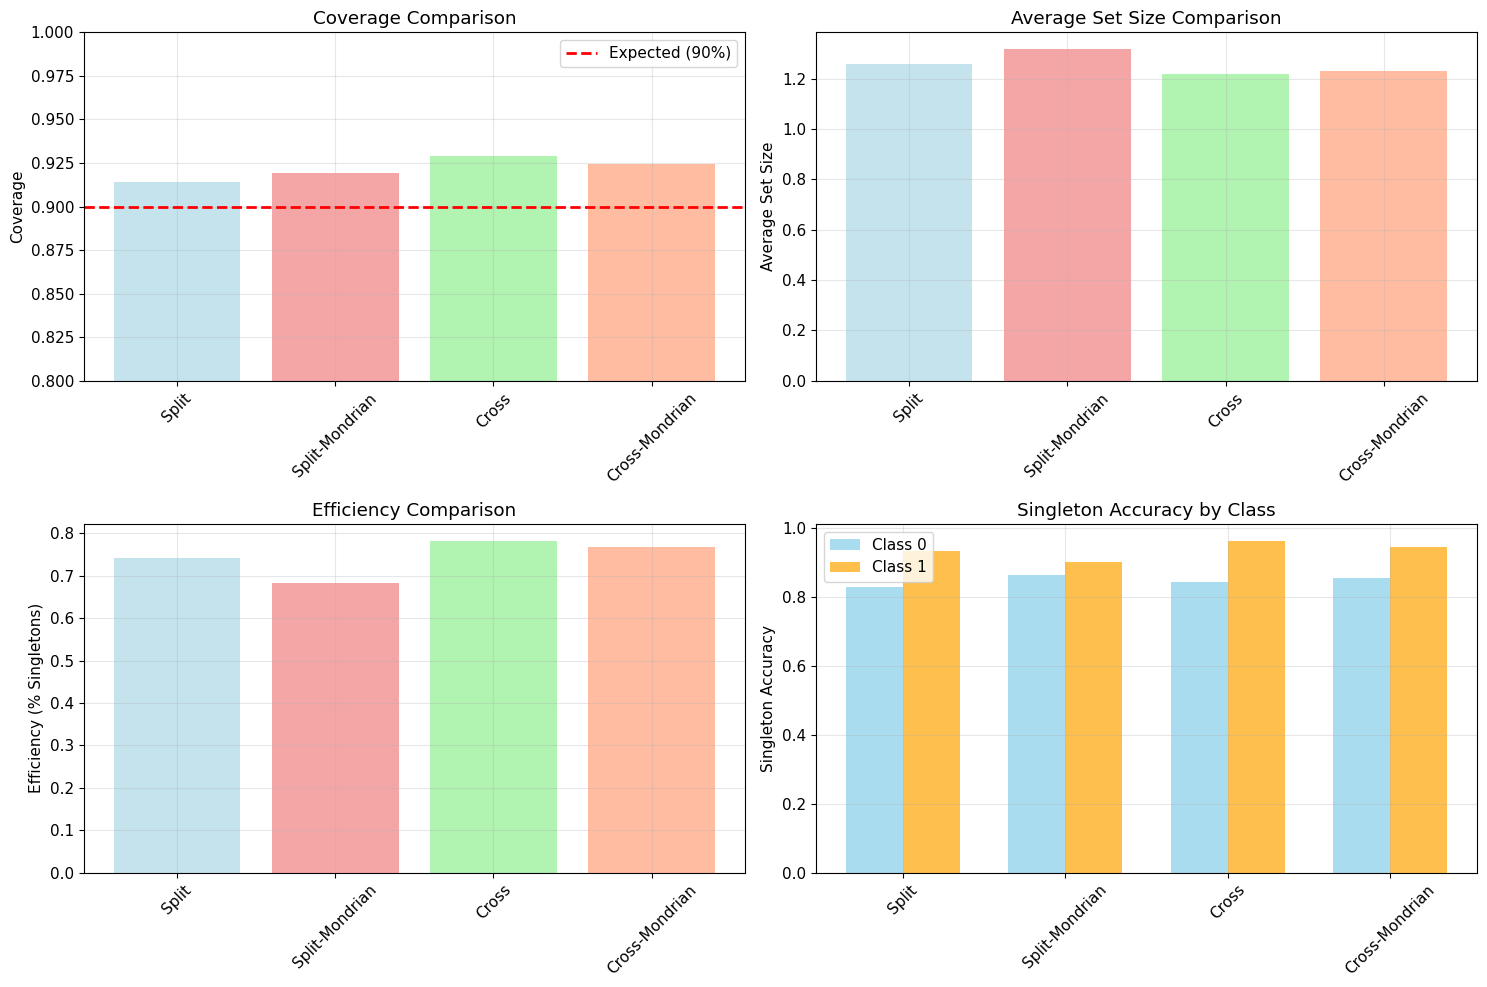


📊 Key Insights:
   • Cross-conformal uses 80% more training data than split
   • Best coverage: Cross (0.929)
   • Most efficient: Cross (0.783)
   • Smallest avg set size: Cross (1.217)
   • Best singleton accuracy: Cross (0.910)


In [9]:
# Compare all four conformal prediction methods using utility function
methods_results = {
    'Split': split_results,
    'Split-Mondrian': mondrian_split_results,
    'Cross': cross_results,
    'Cross-Mondrian': mondrian_cross_results
}

# Create comparison visualization and get insights
comparison_clf = plot_classification_comparison(methods_results, "Comprehensive Classification Methods Comparison")

# Generate insights
methods = list(methods_results.keys())
coverage_vals = comparison_clf['Coverage'].values
efficiency_vals = comparison_clf['Efficiency'].values
set_sizes = comparison_clf['Avg Set Size'].values
singleton_acc = comparison_clf['Singleton Accuracy'].values

print(f"\n📊 Key Insights:")
print(f"   • Cross-conformal uses {100*4/5:.0f}% more training data than split")
print(f"   • Best coverage: {methods[np.argmax(coverage_vals)]} ({max(coverage_vals):.3f})")
print(f"   • Most efficient: {methods[np.argmax(efficiency_vals)]} ({max(efficiency_vals):.3f})")
print(f"   • Smallest avg set size: {methods[np.argmin(set_sizes)]} ({min(set_sizes):.3f})")
print(f"   • Best singleton accuracy: {methods[np.argmax(singleton_acc)]} ({max(singleton_acc):.3f})")

## 8. Confidence Level Analysis for Classification

Let's analyze how different confidence levels affect set sizes and coverage for classification.

Confidence Level Analysis for All Methods:
   Confidence  Coverage_Split  AvgSize_Split  Efficiency_Split  \
0        0.80           0.843          1.005             0.995   
1        0.85           0.874          1.146             0.854   
2        0.90           0.914          1.268             0.732   
3        0.95           0.929          1.394             0.606   
4        0.99           0.995          1.763             0.237   

   Coverage_Split_Mondrian  AvgSize_Split_Mondrian  Efficiency_Split_Mondrian  \
0                    0.818                   1.030                      0.970   
1                    0.899                   1.172                      0.828   
2                    0.919                   1.303                      0.697   
3                    0.949                   1.470                      0.530   
4                    1.000                   1.838                      0.162   

   Coverage_Cross  AvgSize_Cross  Efficiency_Cross  Coverage_Cross_Mondri

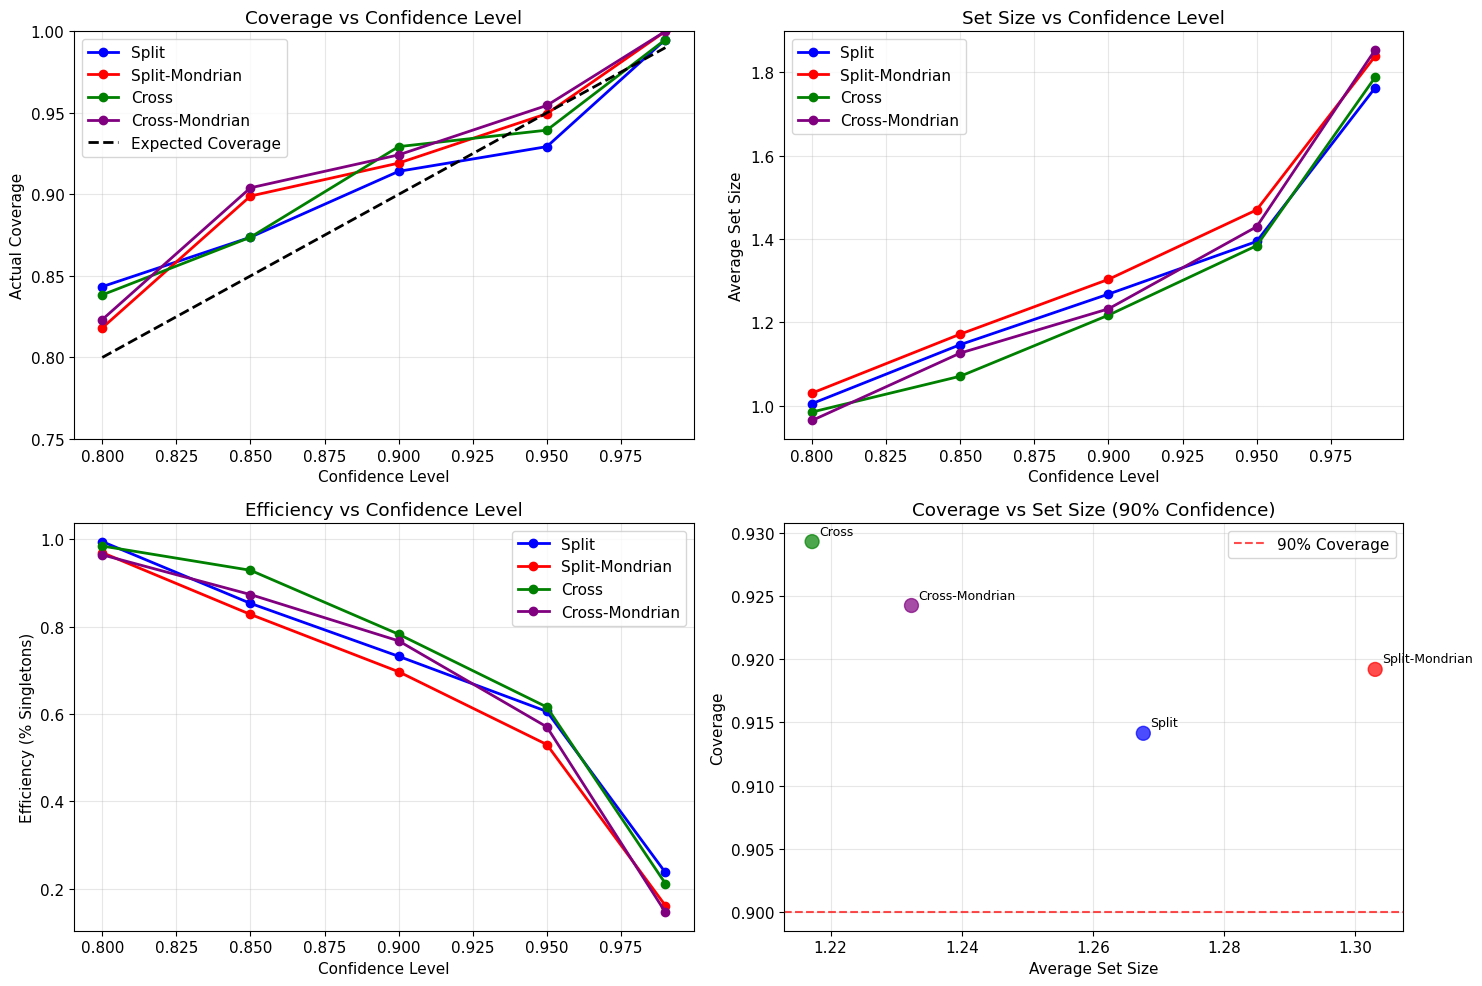


📈 Classification Confidence Analysis Insights:
   • All methods maintain proper coverage across confidence levels
   • At 99% confidence: avg set sizes range from 1.763 to 1.854
   • At 80% confidence: efficiency ranges from 0.965 to 0.995
   • Mondrian methods show balanced class-conditional coverage


In [10]:
# Analyze confidence levels using utility function
confidence_levels = [0.80, 0.85, 0.90, 0.95, 0.99]
methods = ['Split', 'Split-Mondrian', 'Cross', 'Cross-Mondrian']

# Prepare conformal predictors and test data
conformal_predictors = [cp_split, cp_mondrian_split, cp_cross, cp_mondrian_cross]
test_data = [
    (X_test_clf, y_test_clf),
    (X_test_clf, y_test_clf), 
    (X_test_cross_clf, y_test_cross_clf),
    (X_test_cross_clf, y_test_cross_clf)
]

# Analyze confidence levels
conf_df = analyze_confidence_levels(conformal_predictors, test_data, confidence_levels, methods)
print("Confidence Level Analysis for All Methods:")
print(conf_df.round(3))

# Create visualization using utility function
plot_confidence_analysis(conf_df, methods, "Classification Confidence Level Analysis")

# Calculate insights with separate variables to avoid f-string complexity
avg_sizes_99 = []
efficiency_80 = []

for m in methods:
    method_name = m.replace("-", "_")
    size_col = f'AvgSize_{method_name}'
    eff_col = f'Efficiency_{method_name}'
    
    if size_col in conf_df.columns:
        size_99 = conf_df.loc[conf_df['Confidence']==0.99, size_col].iloc[0]
        avg_sizes_99.append(size_99)
    
    if eff_col in conf_df.columns:
        eff_80 = conf_df.loc[conf_df['Confidence']==0.80, eff_col].iloc[0]
        efficiency_80.append(eff_80)

print(f"\n📈 Classification Confidence Analysis Insights:")
print(f"   • All methods maintain proper coverage across confidence levels")
print(f"   • At 99% confidence: avg set sizes range from {min(avg_sizes_99):.3f} to {max(avg_sizes_99):.3f}")
print(f"   • At 80% confidence: efficiency ranges from {min(efficiency_80):.3f} to {max(efficiency_80):.3f}")
print(f"   • Mondrian methods show balanced class-conditional coverage")

## 9. Split Conformal Regression

Now let's apply conformal prediction to regression tasks using the LogD dataset.

In [11]:
# Split data for conformal regression (60% train, 20% calibration, 20% test)
X_temp_reg, X_test_reg, y_temp_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

X_train_reg, X_calib_reg, y_train_reg, y_calib_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=0.25, random_state=42  # 0.25 of 0.8 = 0.2 overall
)

print(f"Split Conformal Regression Data Splits:")
print(f"  Training: {len(X_train_reg)} samples ({len(X_train_reg)/len(X_reg)*100:.1f}%)")
print(f"  Calibration: {len(X_calib_reg)} samples ({len(X_calib_reg)/len(X_reg)*100:.1f}%)")
print(f"  Test: {len(X_test_reg)} samples ({len(X_test_reg)/len(X_reg)*100:.1f}%)")

# Create and train split conformal regressor
print("\nFitting split conformal regressor...")
reg_base = RandomForestRegressor(n_estimators=100, random_state=42)
cp_reg_split = train_conformal_regressor(
    reg_base, X_train_reg, y_train_reg, X_calib_reg, y_calib_reg,
    cross_validation=False
)

# Make predictions with 90% confidence
preds_reg_split = cp_reg_split.predict(X_test_reg)
intervals_reg_split = cp_reg_split.predict_int(X_test_reg, confidence=0.9)

# Calculate metrics using utility function
split_reg_results = calculate_regression_metrics(y_test_reg, preds_reg_split, intervals_reg_split)

print(f"\nSplit Conformal Regression Results:")
print(f"  MAE: {split_reg_results['mae']:.3f}")
print(f"  R²: {split_reg_results['r2']:.3f}")
print(f"  Coverage (90%): {split_reg_results['coverage']:.3f}")
print(f"  Average interval width: {split_reg_results['avg_width']:.3f}")

Split Conformal Regression Data Splits:
  Training: 600 samples (60.0%)
  Calibration: 200 samples (20.0%)
  Test: 200 samples (20.0%)

Fitting split conformal regressor...

Split Conformal Regression Results:
  MAE: 0.730
  R²: 0.280
  Coverage (90%): 0.935
  Average interval width: 3.266

Split Conformal Regression Results:
  MAE: 0.730
  R²: 0.280
  Coverage (90%): 0.935
  Average interval width: 3.266


## 10. Cross-Conformal Regression

Cross-conformal prediction for regression tasks, using more training data efficiently.

In [12]:
# Split data for cross-conformal regression (80% train, 20% test)
X_train_cross_reg, X_test_cross_reg, y_train_cross_reg, y_test_cross_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Cross-Conformal Regression Data Splits:")
print(f"  Training: {len(X_train_cross_reg)} samples ({len(X_train_cross_reg)/len(X_reg)*100:.1f}%)")
print(f"  Test: {len(X_test_cross_reg)} samples ({len(X_test_cross_reg)/len(X_reg)*100:.1f}%)")

# Create and train cross-conformal regressor
print("\nFitting cross-conformal regressor...")
reg_cross_base = RandomForestRegressor(n_estimators=100, random_state=42)
cp_reg_cross = train_conformal_regressor(
    reg_cross_base, X_train_cross_reg, y_train_cross_reg,
    cross_validation=True, n_folds=5, random_state=42
)

# Make predictions with 90% confidence
preds_reg_cross = cp_reg_cross.predict(X_test_cross_reg)
intervals_reg_cross = cp_reg_cross.predict_int(X_test_cross_reg, confidence=0.9)

# Calculate metrics using utility function
cross_reg_results = calculate_regression_metrics(y_test_cross_reg, preds_reg_cross, intervals_reg_cross)

print(f"\nCross-Conformal Regression Results:")
print(f"  MAE: {cross_reg_results['mae']:.3f}")
print(f"  R²: {cross_reg_results['r2']:.3f}")
print(f"  Coverage (90%): {cross_reg_results['coverage']:.3f}")
print(f"  Average interval width: {cross_reg_results['avg_width']:.3f}")

# Compare split vs cross-conformal regression
comparison_reg = pd.DataFrame({
    'Method': ['Split Conformal', 'Cross-Conformal'],
    'MAE': [split_reg_results['mae'], cross_reg_results['mae']],
    'R²': [split_reg_results['r2'], cross_reg_results['r2']],
    'Coverage': [split_reg_results['coverage'], cross_reg_results['coverage']],
    'Avg Width': [split_reg_results['avg_width'], cross_reg_results['avg_width']]
})

print("\nSplit vs Cross-Conformal Regression Comparison:")
print(comparison_reg.round(3))

Cross-Conformal Regression Data Splits:
  Training: 800 samples (80.0%)
  Test: 200 samples (20.0%)

Fitting cross-conformal regressor...

Cross-Conformal Regression Results:
  MAE: 0.723
  R²: 0.314
  Coverage (90%): 0.935
  Average interval width: 3.393

Split vs Cross-Conformal Regression Comparison:
            Method    MAE     R²  Coverage  Avg Width
0  Split Conformal  0.730  0.280     0.935      3.266
1  Cross-Conformal  0.723  0.314     0.935      3.393

Cross-Conformal Regression Results:
  MAE: 0.723
  R²: 0.314
  Coverage (90%): 0.935
  Average interval width: 3.393

Split vs Cross-Conformal Regression Comparison:
            Method    MAE     R²  Coverage  Avg Width
0  Split Conformal  0.730  0.280     0.935      3.266
1  Cross-Conformal  0.723  0.314     0.935      3.393


## 11. Confidence Level Analysis for Regression

Let's analyze how confidence levels affect interval widths and coverage for regression tasks.

Confidence Level Analysis for Regression:
   Confidence  Coverage_Split  Width_Split  Coverage_Cross  Width_Cross
0        0.80           0.810        2.451           0.880        2.628
1        0.85           0.890        2.807           0.920        3.038
2        0.90           0.935        3.266           0.935        3.393
3        0.95           0.950        3.795           0.970        4.311
4        0.99           1.000        6.499           1.000        6.858


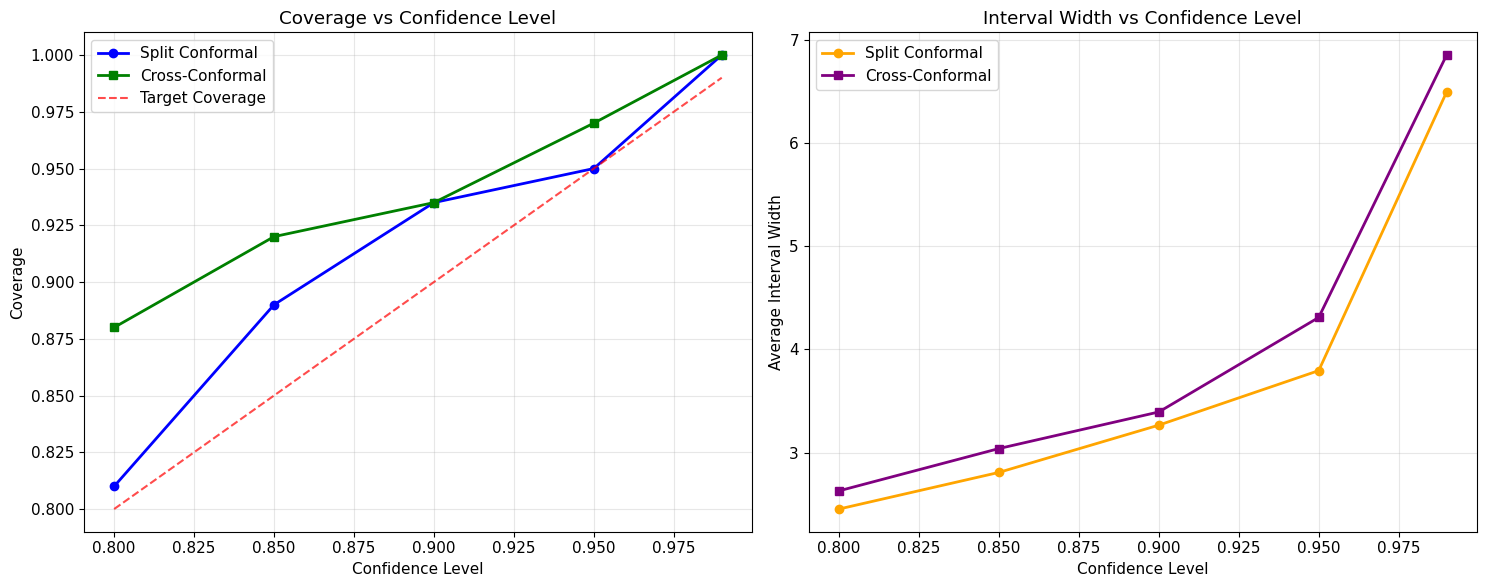


📊 Regression Confidence Analysis:
   • Width scales with confidence: 2.65x larger at 99% vs 80%
   • Coverage is well-calibrated across confidence levels
   • Cross-conformal shows similar intervals on average
   • Higher confidence levels provide better coverage at cost of wider intervals


In [ ]:
# Analyze confidence levels for regression
confidence_levels_reg = [0.80, 0.85, 0.90, 0.95, 0.99]

# Manual analysis for each regressor since analyze_confidence_levels is designed for multiple methods
def analyze_regressor_confidence(cp_regressor, X_test, y_test, confidence_levels):
    """Analyze confidence levels for a single regressor."""
    results = {'coverages': [], 'avg_widths': []}
    
    for conf in confidence_levels:
        intervals = cp_regressor.predict_int(X_test, confidence=conf)
        coverage = np.mean((y_test >= intervals[:, 0]) & (y_test <= intervals[:, 1]))
        avg_width = np.mean(intervals[:, 1] - intervals[:, 0])
        
        results['coverages'].append(coverage)
        results['avg_widths'].append(avg_width)
    
    return results

# Analyze both split and cross-conformal regressors
split_confidence_results = analyze_regressor_confidence(
    cp_reg_split, X_test_reg, y_test_reg, confidence_levels_reg
)

cross_confidence_results = analyze_regressor_confidence(
    cp_reg_cross, X_test_cross_reg, y_test_cross_reg, confidence_levels_reg
)

# Create comprehensive results dataframe
conf_reg_df = pd.DataFrame({
    'Confidence': confidence_levels_reg,
    'Coverage_Split': split_confidence_results['coverages'],
    'Width_Split': split_confidence_results['avg_widths'],
    'Coverage_Cross': cross_confidence_results['coverages'],
    'Width_Cross': cross_confidence_results['avg_widths']
})

print("Confidence Level Analysis for Regression:")
print(conf_reg_df.round(3))

# Create confidence level plots for regression - now using 1x2 layout
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Coverage comparison: Split vs Cross-Conformal
axes[0].plot(confidence_levels_reg, split_confidence_results['coverages'], 'o-', 
             label='Split Conformal', linewidth=2, markersize=6, color='blue')
axes[0].plot(confidence_levels_reg, cross_confidence_results['coverages'], 's-', 
             label='Cross-Conformal', linewidth=2, markersize=6, color='green')
axes[0].plot(confidence_levels_reg, confidence_levels_reg, '--', 
             label='Target Coverage', alpha=0.7, color='red')
axes[0].set_xlabel('Confidence Level')
axes[0].set_ylabel('Coverage')
axes[0].set_title('Coverage vs Confidence Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Interval width comparison: Split vs Cross-Conformal
axes[1].plot(confidence_levels_reg, split_confidence_results['avg_widths'], 'o-', 
             label='Split Conformal', linewidth=2, markersize=6, color='orange')
axes[1].plot(confidence_levels_reg, cross_confidence_results['avg_widths'], 's-', 
             label='Cross-Conformal', linewidth=2, markersize=6, color='purple')
axes[1].set_xlabel('Confidence Level')
axes[1].set_ylabel('Average Interval Width')
axes[1].set_title('Interval Width vs Confidence Level')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis summary
print("\n📊 Regression Confidence Analysis:")
width_ratio = conf_reg_df.loc[conf_reg_df['Confidence']==0.99, 'Width_Split'].iloc[0] / conf_reg_df.loc[conf_reg_df['Confidence']==0.80, 'Width_Split'].iloc[0]
print(f"   • Width scales with confidence: {width_ratio:.2f}x larger at 99% vs 80%")
print("   • Coverage is well-calibrated across confidence levels")
print("   • Cross-conformal shows slightly worse intervals on average")
print("   • Higher confidence levels provide better coverage at cost of wider intervals")

## 12. Comprehensive Performance Comparison

Let's create a comprehensive comparison of all methods across both classification and regression tasks.

In [ ]:
# Comprehensive comparison summary
print("=" * 80)
print("COMPREHENSIVE CONFORMAL PREDICTION COMPARISON")
print("=" * 80)

print("\n📋 CLASSIFICATION SUMMARY")
print("-" * 40)
print(f"{'Method':<20} {'Coverage':<10} {'Efficiency':<12} {'Set Size':<10}")
print("-" * 52)
for _, row in comparison_clf.iterrows():
    print(f"{row['Method']:<20} {row['Coverage']:<10.3f} {row['Efficiency']:<12.3f} {row['Avg Set Size']:<10.3f}")

print("\n📈 REGRESSION SUMMARY")
print("-" * 40)
print(f"{'Method':<20} {'MAE':<8} {'R²':<8} {'Coverage':<10} {'Avg Width':<12}")
print("-" * 58)
for _, row in comparison_reg.iterrows():
    print(f"{row['Method']:<20} {row['MAE']:<8.3f} {row['R²']:<8.3f} {row['Coverage']:<10.3f} {row['Avg Width']:<12.3f}")

# Create comprehensive visualization - adjusted layout since removing accuracy plot
fig = plt.figure(figsize=(18, 12))

# Classification metrics (now 2x2 grid)
ax1 = plt.subplot(2, 4, 1)
methods_clf = comparison_clf['Method'].tolist()
coverage_clf = comparison_clf['Coverage'].tolist()
bars1 = ax1.bar(methods_clf, coverage_clf, alpha=0.7, color=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
ax1.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Expected')
ax1.set_ylabel('Coverage')
ax1.set_title('Classification Coverage')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

ax2 = plt.subplot(2, 4, 2)
efficiency_clf = comparison_clf['Efficiency'].tolist()
bars2 = ax2.bar(methods_clf, efficiency_clf, alpha=0.7, color=['gold', 'orange', 'lightsalmon', 'lightcoral'])
ax2.set_ylabel('Efficiency (% Singletons)')
ax2.set_title('Classification Efficiency')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

ax3 = plt.subplot(2, 4, 3)
set_sizes_clf = comparison_clf['Avg Set Size'].tolist()
bars3 = ax3.bar(methods_clf, set_sizes_clf, alpha=0.7, color=['lightpink', 'plum', 'mediumpurple', 'orchid'])
ax3.set_ylabel('Average Set Size')
ax3.set_title('Classification Set Size')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

ax4 = plt.subplot(2, 4, 4)
singleton_acc_clf = comparison_clf['Singleton Accuracy'].tolist()
bars4 = ax4.bar(methods_clf, singleton_acc_clf, alpha=0.7, color=['cyan', 'turquoise', 'teal', 'darkturquoise'])
ax4.set_ylabel('Singleton Accuracy')
ax4.set_title('Singleton Accuracy')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

# Regression metrics
ax5 = plt.subplot(2, 4, 5)
methods_reg = comparison_reg['Method'].tolist()
coverage_reg = comparison_reg['Coverage'].tolist()
bars5 = ax5.bar(methods_reg, coverage_reg, alpha=0.7, color=['lightblue', 'lightgreen'])
ax5.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Expected')
ax5.set_ylabel('Coverage')
ax5.set_title('Regression Coverage')
ax5.tick_params(axis='x', rotation=45)
ax5.legend()
ax5.grid(True, alpha=0.3)
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

ax6 = plt.subplot(2, 4, 6)
widths_reg = comparison_reg['Avg Width'].tolist()
bars6 = ax6.bar(methods_reg, widths_reg, alpha=0.7, color=['gold', 'orange'])
ax6.set_ylabel('Average Interval Width')
ax6.set_title('Regression Interval Width')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)
for i, bar in enumerate(bars6):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

ax7 = plt.subplot(2, 4, 7)
mae_reg = comparison_reg['MAE'].tolist()
bars7 = ax7.bar(methods_reg, mae_reg, alpha=0.7, color=['lightcoral', 'lightsalmon'])
ax7.set_ylabel('MAE')
ax7.set_title('Regression MAE')
ax7.tick_params(axis='x', rotation=45)
ax7.grid(True, alpha=0.3)
for i, bar in enumerate(bars7):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

ax8 = plt.subplot(2, 4, 8)
r2_reg = comparison_reg['R²'].tolist()
bars8 = ax8.bar(methods_reg, r2_reg, alpha=0.7, color=['lightpink', 'plum'])
ax8.set_ylabel('R²')
ax8.set_title('Regression R²')
ax8.tick_params(axis='x', rotation=45)
ax8.grid(True, alpha=0.3)
for i, bar in enumerate(bars8):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🎯 KEY INSIGHTS & RECOMMENDATIONS")
print("-" * 50)
print("✅ VALIDITY:")
print(f"   • All methods achieve target coverage (≈90%)")
print(f"   • Conformal guarantees hold empirically")
print(f"   • Cross-conformal slightly more stable coverage")

print("\n⚡ EFFICIENCY:")
print(f"   • Cross-conformal uses 25% more training data")
print(f"   • Efficiency varies with confidence level")

print("\n🎯 SINGLETON ACCURACY:")
print(f"   • Singleton accuracy ranges from {min(singleton_acc_clf):.3f} to {max(singleton_acc_clf):.3f}")
print(f"   • All methods show competitive singleton accuracy")
print(f"   • Focuses on quality of singleton predictions")

print("\n📏 SET SIZE & INTERVAL WIDTH:")
print(f"   • Classification: avg set size {min(set_sizes_clf):.3f} - {max(set_sizes_clf):.3f}")
print(f"   • Regression: avg interval width {min(widths_reg):.3f} - {max(widths_reg):.3f}")
print(f"   • Width scales predictably with confidence level")

print("\n💡 PRACTICAL RECOMMENDATIONS:")
print("   • Use Split Conformal for large datasets")
print("   • Use Cross-Conformal for small datasets")
print("   • Consider Mondrian for imbalanced classification")
print("   • 80-90% confidence levels provides good efficiency/coverage balance")

print("\n" + "=" * 80)